# Example Stock Linear Embedding

## Algorithm

### Data Preprocessing:

- We fetch one year of daily closing prices for 20 stocks, compute daily returns, and arrange the data so that each stock is represented by a 252-dimensional feature vector.
### Autoencoder (AE):

- The StockAE class defines a simple AE with an encoder (compressing to a 32-dimensional latent space) and a decoder (reconstructing the 252-dimensional input).
- The loss function (MSELoss) measures the reconstruction error.
### Attention Module:

- In the StockModel, the AE is used to produce latent representations.
A multi-head self-attention layer then refines these embeddings.
We reshape the embeddings to add a dummy batch dimension to comply with the attention layer's expected input shape.
### Training:

- The model is trained for 500 epochs using Adam optimizer to minimize the reconstruction loss of the AE.
The attention module is trained jointly even though its outputs are not directly supervised here.
### Visualization:

- PCA is used to reduce dimensions for visualization at three stages: raw inputs, AE-encoded representations, and post-attention representations.
A heatmap of the attention weights shows the inter-stock relationships learned by the self-attention mechanism.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


Epoch 50/500, Loss: 0.000209
Epoch 100/500, Loss: 0.000107
Epoch 150/500, Loss: 0.000076
Epoch 200/500, Loss: 0.000049
Epoch 250/500, Loss: 0.000029
Epoch 300/500, Loss: 0.000019
Epoch 350/500, Loss: 0.000013
Epoch 400/500, Loss: 0.000008
Epoch 450/500, Loss: 0.000005
Epoch 500/500, Loss: 0.000004


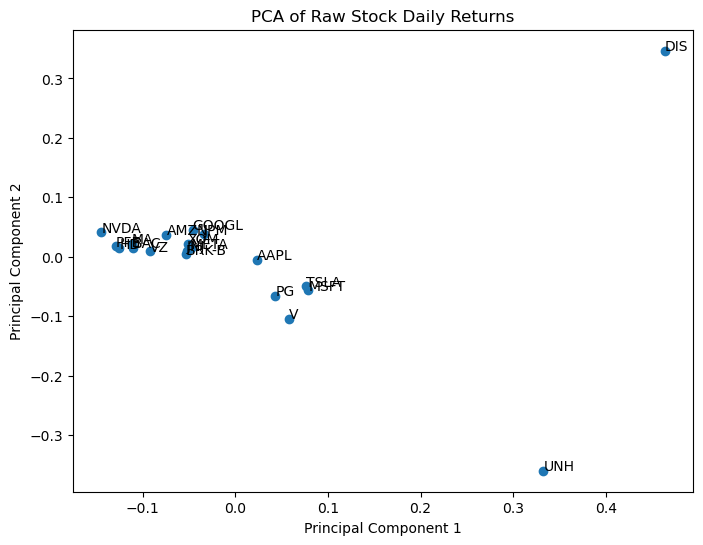

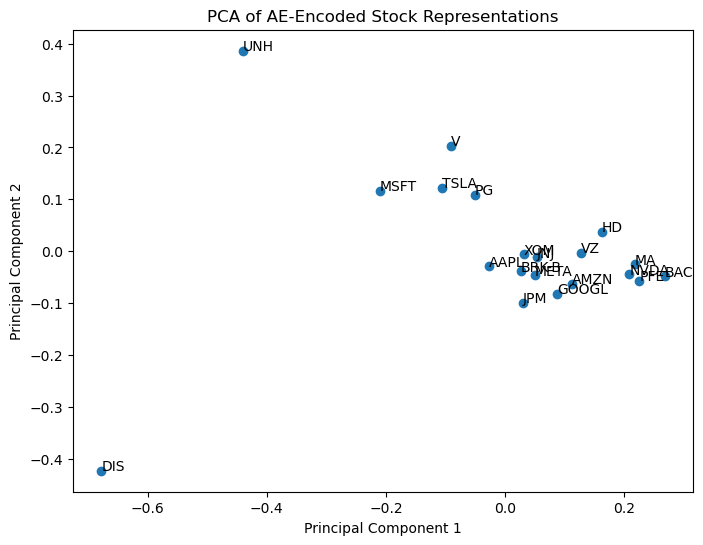

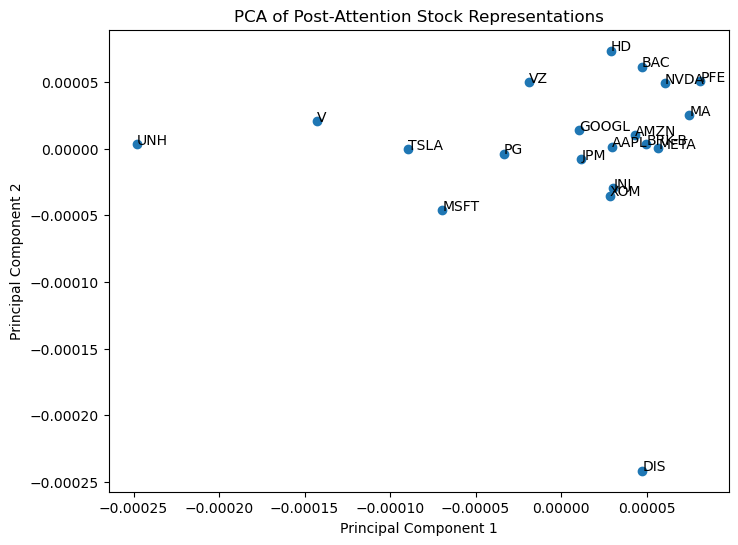

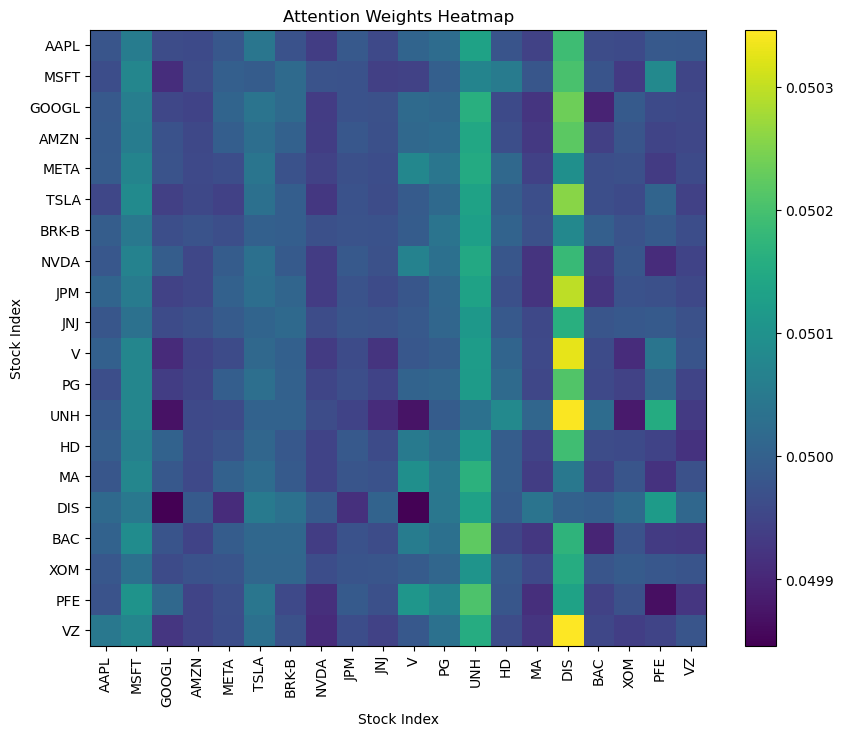

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -------------------------------
# 1. Data Download and Preprocessing
# -------------------------------
# Define 20 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 
           'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 
           'DIS', 'BAC', 'XOM', 'PFE', 'VZ']

# Download one year of daily closing prices
data = yf.download(tickers, period='1y')['Close']
data = data.ffill().dropna()

# Compute daily percentage returns and keep the most recent 252 trading days
returns = data.pct_change().dropna().tail(252)

# Each stock is represented by its daily returns vector (252 dimensions)
# We arrange the data so that each row corresponds to one stock.
stock_features = returns.T.values  # shape: (20, 252)
x = torch.tensor(stock_features, dtype=torch.float)

# -------------------------------
# 2. Define the Autoencoder and Overall Model
# -------------------------------
# Autoencoder: compress input to embed_dim and then reconstruct
class StockAE(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(StockAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

# Overall model: AE for embedding + Multihead Self-Attention layer
class StockModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(StockModel, self).__init__()
        self.ae = StockAE(input_dim, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        
    def forward(self, x):
        # AE: get the latent embedding and reconstruction
        z, x_recon = self.ae(x)  # z shape: (num_stocks, embed_dim)
        
        # Prepare for attention: MultiheadAttention expects (L, N, E)
        # Here, L=num_stocks, N=batch_size. We add a dummy batch dimension.
        z_unsq = z.unsqueeze(1)  # shape becomes (num_stocks, 1, embed_dim)
        
        # Self-attention: use the same tensor for query, key, and value.
        attn_output, attn_weights = self.attention(z_unsq, z_unsq, z_unsq)
        attn_output = attn_output.squeeze(1)  # shape: (num_stocks, embed_dim)
        
        return z, x_recon, attn_output, attn_weights

# Hyperparameters
input_dim = x.shape[1]  # 252
embed_dim = 32          # Latent dimension for the AE
num_heads = 4           # Number of attention heads
learning_rate = 1e-3
num_epochs = 500

# Instantiate the model, loss function, and optimizer
model = StockModel(input_dim, embed_dim, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------------
# 3. Train the Autoencoder (Jointly with the Attention Module)
# -------------------------------
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    z, x_recon, attn_output, attn_weights = model(x)
    
    # Reconstruction loss for the autoencoder
    loss = criterion(x_recon, x)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# -------------------------------
# 4. Evaluate and Visualize the Representations
# -------------------------------
# Switch to evaluation mode and compute final outputs
model.eval()
with torch.no_grad():
    z, x_recon, attn_output, attn_weights = model(x)

# Helper function to visualize using PCA
def plot_pca(data, title, labels):
    # Convert to numpy array if necessary
    if torch.is_tensor(data):
        data = data.detach().numpy()
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
    for i, txt in enumerate(labels):
        plt.annotate(txt, (data_reduced[i, 0], data_reduced[i, 1]))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Visualize the raw input space (daily returns)
plot_pca(x, "PCA of Raw Stock Daily Returns", tickers)

# Visualize the AE-encoded (latent) representations
plot_pca(z, "PCA of AE-Encoded Stock Representations", tickers)

# Visualize the representations after the attention layer
plot_pca(attn_output, "PCA of Post-Attention Stock Representations", tickers)

# -------------------------------
# 5. Visualize the Attention Weights as a Heatmap
# -------------------------------
plt.figure(figsize=(10, 8))
# Remove the dummy batch dimension from attention weights: (1, 20, 20) -> (20, 20)
attn_weights_np = attn_weights.squeeze(0).detach().numpy()
plt.imshow(attn_weights_np, cmap='viridis')
plt.colorbar()
plt.title("Attention Weights Heatmap")
plt.xlabel("Stock Index")
plt.ylabel("Stock Index")
plt.xticks(ticks=np.arange(len(tickers)), labels=tickers, rotation=90)
plt.yticks(ticks=np.arange(len(tickers)), labels=tickers)
plt.show()
